In [1]:
from matplotlib import pyplot as plt
from matplotlib import image as img
import netCDF4 as nc
import numpy as np
import math
from scipy import signal, interpolate

In [2]:
ds= nc.Dataset('../11107hffan_xy-cal.nc', 'r')

In [3]:
x,y = ds.variables['x'], ds.variables['y']
time= ds.variables['time']
Sv=ds.variables['Sv']

In [6]:
x=x[:]
y=y[:]
tidx=-1
Sv = ds.variables['Sv'][tidx, tidx, :, :]

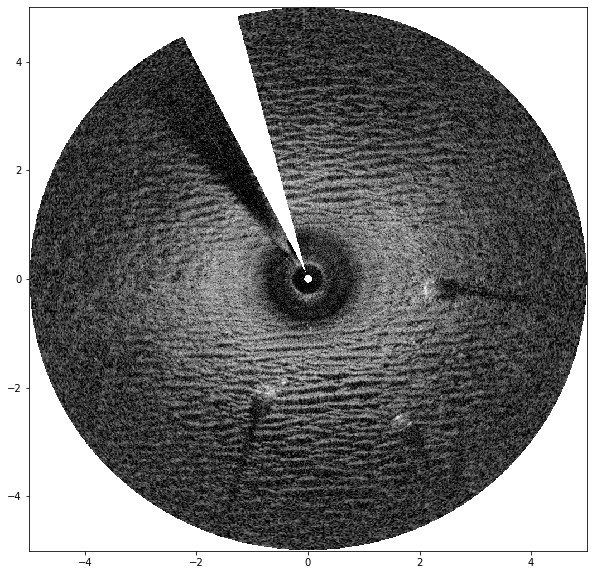

In [5]:
np.shape(Sv)

plt.figure(figsize=[10, 10])
plt.pcolor(x, y, (Sv), cmap='gray')
plt.show()

In [8]:
#Estimated dimensions of one pixel (different from sample)
#Estimated dimensions of one pixel
dx = x[2]-x[1]
dy = y[2]-y[1]

#Create x and y dimensions, as well as edgelength of a subimage
#501 to make the array size 1001, 
x = np.arange(-500*dx, 501*dx, dx)
y = np.arange(-500*dy, 501*dy, dy)
m=256
n=m

squareEdgeLength = 256*dx

In [9]:
def subImageInterp(x, y, z, m, n):
    #This function creates and interpolates over the subimage region
    #Input:
    #     x: coordinates in the x direction
    #     y: coordinates in the y direction
    #     z: z = f(x, y) i.e. sonar return strength, pixel strength
    #     m: number of points in the x direction, ideally a power of 2
    #     n: number of points in the y direction, ideally a power of 2
    #Output:
    #     xInterp: x-coordinates of the interpolated grid
    #     yInterp: y-coordinates of the interpolated grid
    #     zInterp: Interpolated z values
    
    #Define the center
    xCenter = 0.0
    yCenter = 2.5
    
    #Define the 4 corners
    xSquareRange = [xCenter - squareEdgeLength/2., xCenter + squareEdgeLength/2.]
    ySquareRange = [yCenter - squareEdgeLength/2., yCenter + squareEdgeLength/2.]
    
    #Get the datapoints that exist within the subimage
    xMask = np.logical_and(x > xSquareRange[0], x < xSquareRange[1])
    yMask = np.logical_and(y > ySquareRange[0], y < ySquareRange[1])
      
    xReal = x[xMask]
    yReal = y[yMask]
    zReal = z[np.ix_(yMask, xMask)]
        
    #Create the region to interpolate over
    xInterp = np.arange(xSquareRange[0], xSquareRange[1], dx)
    yInterp = np.arange(ySquareRange[0], ySquareRange[1], dy)
    
    #Standardize the size of the regions
    xInterp = xInterp[0:m]
    yInterp = yInterp[0:n]

    #Make the x and y arrays 2-dimensional
    xInterpGrid, yInterpGrid = np.meshgrid(xInterp, yInterp)

    #Reshape the data for the interpolation method
    mTemp = np.size(xReal)
    nTemp = np.size(yReal)
        
    xReal, yReal = np.meshgrid(xReal, yReal)
        
    xReal = xReal.reshape(mTemp*nTemp)
    yReal = yReal.reshape(mTemp*nTemp)
    zReal = zReal.reshape(mTemp*nTemp)
        
    #Perform a scattered interpolant
    zInterp = interpolate.griddata((xReal, yReal), zReal,
                                    (xInterpGrid, yInterpGrid), method='cubic')
        
    #Remove NaNs
    zInterp[np.isnan(zInterp)] = 0
    
    return xInterp, yInterp, zInterp
     
    
    
def spectrum(x, y, z, dx, dy, m, n):
    #Return a power and associated wavenumbers in the x and y direction
    #Input:
    #     x: coordinates in the x direction
    #     y: coordinates in the y direction
    #     z: z = f(x, y) i.e. sonar return strength, pixel strength
    #     dx: step size in the x direction
    #     dy: step size in the y direction
    #     m: number of points in the x direction, ideally a power of 2
    #     n: number of points in the y direction, ideally a power of 2
    #Output:
    #     pZ: power estimate of the fft, pZ = F(kx, ky)
    #     kx: wavenumber in the x direction
    #     ky: wavenumber in the y direction
    
    #First step is to remove a 2nd degree polynomial
    yTrend = np.polyfit(y, z, 2)
    
    xGrid, yGrid = np.meshgrid(x, y)
    
    z = z - np.polyval(yTrend, yGrid)
    
    z = z.transpose()
    
    xTrend = np.polyfit(x, z, 2)
        
    z = z - np.polyval(xTrend, xGrid.transpose())
    
    z = z.transpose()
    
    #Perform the fft
    fftZ = np.fft.fft2(z)
    
    #Estimate power
    pZ = abs(fftZ)**2
    
    pZ[[1, 2, -1], [1, 2 , -1]] = 0
    
    if m%2 == 0:
        pZ[int(m/2+1), :] = 0
    if n%2 == 0:
        pZ[:, int(n/2+1)] = 0
    
    pZ = np.fft.fftshift(pZ)
    
    #Estimate wavenumbers
    xRange = list(range(0, m))
    kx = [((1/2+val/m)%1)-1/2 for val in xRange]
    kx = [val * 2 * math.pi / dx for val in kx]
    kx = np.fft.fftshift(kx)

    yRange = list(range(0, n))
    ky = [((1/2+val/n)%1)-1/2 for val in yRange]
    ky = [val * 2 * math.pi / dy for val in ky]
    ky = np.fft.fftshift(ky)
    
    return pZ, kx, ky
    
def findRipple(x, y, z, m, n):
    #Take ripple image data and return a ripple orientation and wavelength
    #Input:
    #     x: coordinates in the x direction
    #     y: coordinates in the y direction
    #     z: z = f(x, y) i.e. sonar return strength, pixel strength
    #     m, n: number of points for FFT also determine the size of the squarebox
    #     hgt: height of the sonar
    #Output:
    #     theta: ripple orientation
    #     wavelength: ripple wavelength
    
    
    #Define parameters
    
    #rot = 0
    #north = 90 
    imgRange = 1
    dx = x[1] - x[0]
    dy = y[1] - y[0]
    
    print('dx:',dx)
    maxRange = imgRange
    
    sizeX, sizeY = np.shape(z)
    
    imgCenterX = x[int(sizeX/2)]
    imgCenterY = y[int(sizeY/2)]
    
    #print(imgCenterX)
    #print(imgCenterY)
    
    #Number of points for FFT
    
#    m = 2048
#    n = 2048

    #Create a Filter
    F=np.array([[0, 1, 0], [1, 2, 1], [0, 1, 0]])
    F=F/F.sum()
    
    #Create the subimage
    xInterp, yInterp, zInterp = subImageInterp(x, y, z, m, n)
                                               
    #Perform the fft
    pZ, kx, ky = spectrum(xInterp, yInterp, zInterp, dx, dy, m, n)
    
    #Remove low values
    xMask = abs(kx) <= 3.3
    yMask = abs(ky) <= 3.3
    
    pZ[np.ix_(xMask, yMask)] = 0
    
    #Apply the filter
    pZ = signal.convolve2d(pZ, F, 'same')
    
    #Get max wavenumber values
    kx, ky = np.meshgrid(kx, ky)
    
    KX = kx[pZ == pZ.max()]
    KY = ky[pZ == pZ.max()]
    
    #If there are multiple points, use the first one
    if type(KX) == np.ndarray:
        KX = KX[0]
        KY = KY[0]
    
    #Calculate the orientation
#    theta=math.atan2(KY/KX)*180/math.pi
    theta=math.atan2(KY, KX)*180/math.pi
#    theta=math.atan(KY/KX)*180/math.pi
#    theta=-(theta-90)
#    theta=theta+90
#    if theta < 0:
#        theta += 360
#    if theta >= 180:
#        theta -= 180
    
    #Caulculate the wavelength
    wavelength = 2*math.pi/math.sqrt(KX**2 + KY**2)
    
    return theta, wavelength, xInterp, yInterp, zInterp


In [10]:


# why  do we flip the image before sending it to the ripple calculator
img1 = np.flip(Sv)
#print(img1)
print(np.shape(img1))
#print(np.shape(x))
#Get the orientation and dimensions

theta, wavelength, xInterp, yInterp, zInterp = findRipple(x, y, img1, m, n)
print('theta:',theta)
print('wavelength:',wavelength)

(1001, 1001)
dx: 0.009999752044677734
theta: -81.86989764584403
wavelength: 0.18101484751297714


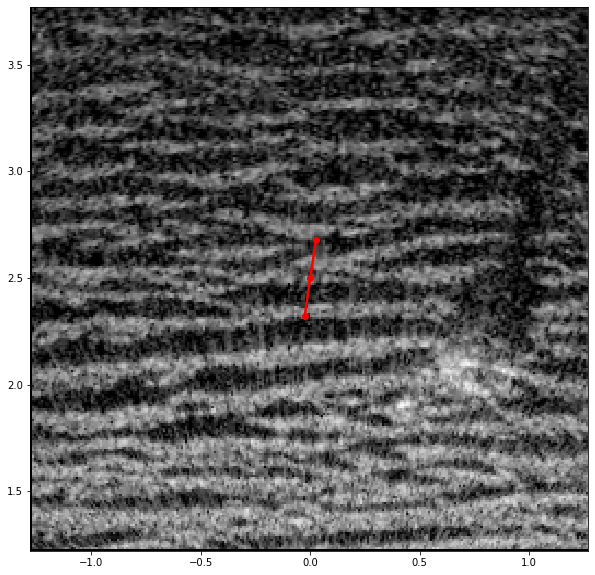

In [11]:
 #Define the center
xCenter = 0.0
yCenter = 2.5

plt.figure(figsize=[10, 10])
plt.pcolor(xInterp, yInterp, zInterp, cmap='gray')
xPlot = [-wavelength*math.cos(math.radians(-(theta)))+xCenter, 0,
                    wavelength*math.cos(math.radians(-(theta)))]
yPlot = [-wavelength*math.sin(math.radians(-(theta)))+yCenter, 0+yCenter,
                    wavelength*math.sin(math.radians(-(theta)))+yCenter]
plt.plot(xPlot, yPlot, 'ro-', linewidth=2.5)
plt.show()


(1001, 1001)


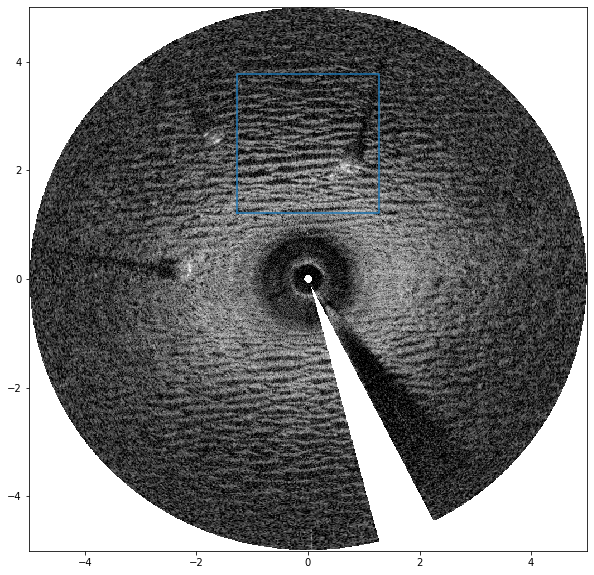

In [13]:
xPlot = [xInterp[0], xInterp[-1], xInterp[-1], xInterp[0], xInterp[0]]
yPlot = [yInterp[0], yInterp[0], yInterp[-1], yInterp[-1], yInterp[0]]

print(np.shape(img1))

plt.figure(figsize=[10, 10])
plt.pcolor(x, y, img1, cmap='gray')
plt.plot(xPlot, yPlot)
plt.show()